# Rehearsal Mechanisms

## Introduction

The rehearsal mechanism is described by Robbins (1995) as a mechanism to mitigate the effects of catastrophic forgetting. They even went as far as postulating that this mechanism is what the human brain used to learn, through replaying old data along with new data during dreaming in sleep. In this notebook, we will explore the effects of rehearsal and pseudorehearsals on a model that is trained to do MNIST digit classification.

In [1]:
# As always, we start with package imports
import copy
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision.transforms import ToTensor, Compose, Pad
from tqdm.notebook import tqdm

# From my pytorch-patterns package
from patterns.utils import train_epoch, calculate_error, validate

## Customize Dataset

Unlike classification tasks, we can't just use the MNIST dataset as is. To investigate catastrophic forgetting, we need to holdout the samples of 1 class of labels. To do this, we need to build a new PyTorch dataset.

In [2]:
class CFMNIST(torchvision.datasets.MNIST):
    
    def __init__(
        self, root, 
        train=True, 
        download=False, 
        transform=None, 
        target_transform=None,
        holdout_label=9,
        holdout=True,
    ):
        super().__init__(
            root, 
            train=train, 
            download=download, 
            transform=transform, 
            target_transform=target_transform
        )
        
        imgs, labels = self._load_data()
        
        if holdout:
            mask = labels != holdout_label
        else:
            mask = labels == holdout_label
            
        self.data = imgs[mask]
        self.targets = labels[mask]

In [3]:
transforms = Compose([
    ToTensor(),
    Pad(2)
])
trainset = CFMNIST(".", download=True, transform=transforms)
validationset = CFMNIST(".", download=True, train=False, transform=transforms)
print(trainset)
print(validationset)

Dataset CFMNIST
    Number of datapoints: 54051
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=2, fill=0, padding_mode=constant)
           )
Dataset CFMNIST
    Number of datapoints: 8991
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=2, fill=0, padding_mode=constant)
           )


In [4]:
train_loader = torch.utils.data.DataLoader(
                    trainset, 
                    batch_size=64, 
                    shuffle=True,
                    num_workers=2
                )

val_loader = torch.utils.data.DataLoader(
                    validationset, 
                    batch_size=64, 
                    shuffle=True,
                    num_workers=2
                )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training LeNet5

Next, we pre-train a LeNet5 while holding out the label 9 to get a model that can classify MNIST 0 - 8. We store the best model based.

In [5]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.ReLU(inplace=True),
        )
        
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, img):
        X = self.convnet(img)
        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)
        X = nn.functional.relu(X)
        X = self.fc2(X)
        return X

### Model Pre-training

In the next section, we will pre-train the model to recognize 0 - 8. If a trained model is already available, we should skip to the next section on rehearsals,

In [6]:
# Setup training
model = LeNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
# Epoch Training
num_epochs = 40

best_verror = 1_000_000

for epoch in tqdm(range(num_epochs)):
    
    # Inner training loop
    avg_loss = train_epoch(
        model, train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    
    # Inner validation loop
    avg_vloss, avg_verror = validate(
        model, val_loader, criterion=criterion, device=device)
    
    if avg_verror < best_verror:
        best_verror = avg_verror
        torch.save(model.state_dict(), "best-model.pth")
        
    tqdm.write(
        f"Epoch: {epoch}, " \
        f"Train loss: {avg_loss:.3f}, " \
        f"Validation loss: {avg_vloss:.3f}, " \
        f"Validation error: {avg_verror:.3f}"
    )

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 0, Train loss: 2.264, Validation loss: 2.224, Validation error: 0.795


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.681, Validation loss: 0.522, Validation error: 0.159


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.375, Validation loss: 0.272, Validation error: 0.086


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.258, Validation loss: 0.212, Validation error: 0.066


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.206, Validation loss: 0.167, Validation error: 0.049


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.168, Validation loss: 0.138, Validation error: 0.041


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.146, Validation loss: 0.124, Validation error: 0.038


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.128, Validation loss: 0.115, Validation error: 0.035


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.115, Validation loss: 0.106, Validation error: 0.033


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.106, Validation loss: 0.092, Validation error: 0.029


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.097, Validation loss: 0.092, Validation error: 0.028


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.090, Validation loss: 0.079, Validation error: 0.025


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.083, Validation loss: 0.078, Validation error: 0.025


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.078, Validation loss: 0.075, Validation error: 0.023


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.073, Validation loss: 0.069, Validation error: 0.022


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.070, Validation loss: 0.064, Validation error: 0.020


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.066, Validation loss: 0.065, Validation error: 0.021


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 17, Train loss: 0.062, Validation loss: 0.058, Validation error: 0.017


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 18, Train loss: 0.060, Validation loss: 0.061, Validation error: 0.019


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 19, Train loss: 0.057, Validation loss: 0.060, Validation error: 0.019


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 20, Train loss: 0.055, Validation loss: 0.052, Validation error: 0.017


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 21, Train loss: 0.052, Validation loss: 0.053, Validation error: 0.017


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 22, Train loss: 0.050, Validation loss: 0.052, Validation error: 0.016


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 23, Train loss: 0.047, Validation loss: 0.049, Validation error: 0.016


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 24, Train loss: 0.046, Validation loss: 0.047, Validation error: 0.015


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 25, Train loss: 0.044, Validation loss: 0.049, Validation error: 0.015


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 26, Train loss: 0.042, Validation loss: 0.053, Validation error: 0.017


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 27, Train loss: 0.041, Validation loss: 0.047, Validation error: 0.015


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 28, Train loss: 0.040, Validation loss: 0.052, Validation error: 0.017


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 29, Train loss: 0.039, Validation loss: 0.042, Validation error: 0.013


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 30, Train loss: 0.037, Validation loss: 0.043, Validation error: 0.014


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 31, Train loss: 0.035, Validation loss: 0.043, Validation error: 0.013


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 32, Train loss: 0.034, Validation loss: 0.043, Validation error: 0.013


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 33, Train loss: 0.033, Validation loss: 0.040, Validation error: 0.012


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 34, Train loss: 0.032, Validation loss: 0.041, Validation error: 0.012


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 35, Train loss: 0.031, Validation loss: 0.042, Validation error: 0.013


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 36, Train loss: 0.030, Validation loss: 0.041, Validation error: 0.012


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 37, Train loss: 0.030, Validation loss: 0.039, Validation error: 0.012


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 38, Train loss: 0.029, Validation loss: 0.037, Validation error: 0.011


  0%|          | 0/845 [00:00<?, ?it/s]

Epoch: 39, Train loss: 0.028, Validation loss: 0.039, Validation error: 0.011


## Pseudo-Rehearsals

In pseudorehearsals, the new intervening data will be batched with randomly generated data. The target labels of the randomly generated data are generated by the model in the forward pass. In pseudo-rehearsal mechanism, we then backpropagate this batch as though it is a full dataset. The hope is that the randomly generated data and model generated labels will capture the function representation that was best describing the original training set. This mechanism has the advantage over rehearsal methods when the previous trained data are not available.

In [8]:
newtrainset = CFMNIST(".", download=True, transform=transforms, holdout=False)
newtrainset

Dataset CFMNIST
    Number of datapoints: 5949
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=2, fill=0, padding_mode=constant)
           )

In [9]:
newtrainloader = torch.utils.data.DataLoader(
                    newtrainset, 
                    batch_size=8, 
                    shuffle=True,
                    num_workers=1
                )

In [10]:
# Initialize and load the pre-trained model
model = LeNet()
model.load_state_dict(torch.load("best-model.pth"))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# For sanity, let's validate that this model is good
vloss, verror = validate(model, val_loader, criterion=criterion, device=device)
print(f"Current loss: {vloss: .3f}")
print(f"Current error: {verror: .3f}")
rand_imgs = torch.rand(1, 1, 32, 32)
rand_logits = model(rand_imgs.to(device))
print(torch.softmax(rand_logits, dim=1)[0])

Current loss:  0.037
Current error:  0.011
tensor([5.3113e-08, 2.5569e-13, 2.2814e-07, 2.8133e-06, 1.0543e-08, 1.2379e-08,
        9.2678e-09, 6.2915e-11, 1.0000e+00, 1.7877e-13], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [15]:
# Rehearsal is like a epoch training loop.
# We only batch the data differently.
# This loop is slowed down due to the inner validation loop.
def pseudo_rehearse(
        model, trainloader,
        optimizer=None,
        criterion=torch.nn.CrossEntropyLoss(),
        device=torch.device("cpu"),
        factor=3
    ):
    
    running_loss = []
    running_vloss = []
    running_verror = []
    
    data_size = len(trainloader)
    
    # Make a copy of the model
    old_model = copy.deepcopy(model)
    
    if not optimizer:
        # Default optimizer if one is not provided
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for i, data in tqdm(enumerate(trainloader), total=data_size):
        # Load the new data in minibatch
        imgs, labels = data
        n, c, H, W = imgs.size()
        
        # Generate random tensors for pseudo rehearsals
        # Note: We should train on logits instead of labels,
        # since some inherent bias of the old model always lead to the same label.
        # We should also use old_model instead of model to generate the (img, logits) pair.
        rand_imgs = torch.rand(n * factor, c, H, W)
        rand_logits = old_model(rand_imgs.to(device))
        rand_conf = torch.softmax(rand_logits, dim=1)
        imgs = torch.cat((imgs, rand_imgs), dim=0)
        conf = torch.nn.functional.one_hot(labels, 10)
        labels = torch.cat((conf.to(device), rand_conf))
        
        # Shuffle the data and labels
        indices = torch.randperm(len(labels))
        imgs = imgs[indices]
        labels = labels[indices]
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(imgs.to(device))
        
        # Compute loss and backpropagate error gradients
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Collate training loss
        running_loss.append(loss.item())
        
        vloss, verror = validate(model, val_loader, criterion=criterion, device=device)
        running_vloss.append(vloss)
        running_verror.append(verror)
        
        # Gradient descent
        optimizer.step()
        
    return running_loss, running_vloss, running_verror

In [16]:
# Pseudo Rehearsal
loss, vloss, verror = pseudo_rehearse(model, newtrainloader, optimizer=optimizer, criterion=criterion, device=device)

  0%|          | 0/744 [00:00<?, ?it/s]

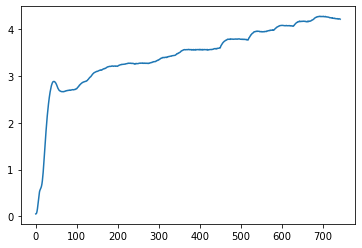

In [18]:
from matplotlib import pyplot as plt

plt.plot(vloss)

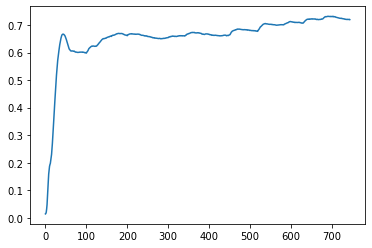

In [19]:
plt.plot(verror)

## Discussion

Somehow pseudorehearsal doesn't work well at all. Model seems to be still not well calibrated. I think this is because I trained with a OHE of 10 labels instead of 9 labels. I need to re-design this. Even then, I am not entirely sure if calibration is the cause of this.

In [22]:
model = LeNet()
model.load_state_dict(torch.load("best-model.pth"))
model = model.to(device)
rand_imgs = torch.rand(16, 1, 32, 32)
rand_logits = model(rand_imgs.to(device))

In [24]:
torch.softmax(rand_logits, dim=1)

tensor([[3.5504e-06, 7.9803e-14, 2.1039e-06, 6.7587e-07, 2.3229e-09, 2.4870e-07,
         3.8513e-07, 9.5756e-13, 9.9999e-01, 7.5057e-14],
        [9.8513e-02, 7.2803e-10, 4.8005e-04, 8.3719e-06, 1.1782e-07, 3.3840e-04,
         1.4446e-04, 6.1818e-08, 9.0052e-01, 9.6415e-11],
        [3.5831e-04, 5.9511e-10, 9.2333e-06, 3.0513e-06, 3.9464e-05, 6.3508e-06,
         1.1961e-03, 6.8528e-10, 9.9839e-01, 1.2167e-11],
        [5.8448e-03, 1.3575e-08, 4.7342e-04, 1.1688e-04, 4.8441e-04, 6.4110e-04,
         2.4900e-03, 2.0255e-08, 9.8995e-01, 4.7631e-10],
        [2.5622e-04, 5.5940e-12, 1.6408e-05, 8.7342e-06, 6.0757e-06, 6.3446e-07,
         7.3036e-05, 3.8434e-10, 9.9964e-01, 4.7390e-12],
        [2.5340e-02, 1.7398e-09, 1.8048e-04, 3.2941e-06, 1.0893e-04, 7.7149e-05,
         1.7987e-03, 4.0372e-08, 9.7249e-01, 1.3292e-10],
        [4.5024e-03, 1.4053e-11, 6.0729e-06, 1.5232e-06, 8.7810e-07, 2.6836e-05,
         3.4106e-04, 2.4135e-09, 9.9512e-01, 1.0946e-11],
        [8.0411e-04, 1.4307